In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
# Importing and cleaning data
# Data provded from optiondata.org
df = pd.read_csv("2013-06-28options.csv")
df = df[df["underlying"] == "AMZN"]
df = df[df["expiration"] == "2015-01-17"]
df.drop(columns = ["underlying", "contract", "bid_size", "ask_size"], inplace = True)

# Dealing with datetime
df["expiration"] = pd.to_datetime(df["expiration"])
df["quote_date"] = pd.to_datetime(df["quote_date"])

# Importing second csv for the underlying
df2 = pd.read_csv("2013-06-28stocks.csv")
df2 = df2[df2["symbol"] == "AMZN"]

df.head()

,expiration,type,strike,style,bid,ask,volume,open_interest,quote_date,delta,gamma,theta,vega,implied_volatility
27363,2015-01-17,call,115.0,A,162.90,166.90,0,1057,2013-06-28,0.9674,0.0004,-2.9919,23.1605,0.4384
27364,2015-01-17,put,115.0,A,2.16,2.55,15,1182,2013-06-28,-0.0314,0.0005,-3.5068,24.4231,0.4479
27365,2015-01-17,call,120.0,A,158.45,162.30,0,89,2013-06-28,0.9607,0.0005,-3.6391,27.3864,0.4430
27366,2015-01-17,put,120.0,A,2.48,2.81,0,263,2013-06-28,-0.0353,0.0005,-3.7980,26.9424,0.4398
27367,2015-01-17,call,125.0,A,153.65,157.75,0,79,2013-06-28,0.9565,0.0005,-3.9375,29.9710,0.4345


In [5]:
# Defining variables
K = df["strike"]
vol = df["implied_volatility"]
T = df["expiration_days"] = (df["expiration"] - df["quote_date"])
T = T.dt.days / 365
r = df["risk_free_rate"] = 0.252 # According to U.S. Treasury on 2013-06-28
q = df["dividend_yield"] = 0

# Inserting the underlying into df
S = df2["close"][179]
S = np.full(K.shape, S)
S = df["close"] = S

df.head()

,expiration,type,strike,style,bid,ask,volume,open_interest,quote_date,delta,gamma,theta,vega,implied_volatility,expiration_days,risk_free_rate,dividend_yield,close
27363,2015-01-17,call,115.0,A,162.90,166.90,0,1057,2013-06-28,0.9674,0.0004,-2.9919,23.1605,0.4384,568 days,0.252,0,277.690002
27364,2015-01-17,put,115.0,A,2.16,2.55,15,1182,2013-06-28,-0.0314,0.0005,-3.5068,24.4231,0.4479,568 days,0.252,0,277.690002
27365,2015-01-17,call,120.0,A,158.45,162.30,0,89,2013-06-28,0.9607,0.0005,-3.6391,27.3864,0.4430,568 days,0.252,0,277.690002
27366,2015-01-17,put,120.0,A,2.48,2.81,0,263,2013-06-28,-0.0353,0.0005,-3.7980,26.9424,0.4398,568 days,0.252,0,277.690002
27367,2015-01-17,call,125.0,A,153.65,157.75,0,79,2013-06-28,0.9565,0.0005,-3.9375,29.9710,0.4345,568 days,0.252,0,277.690002


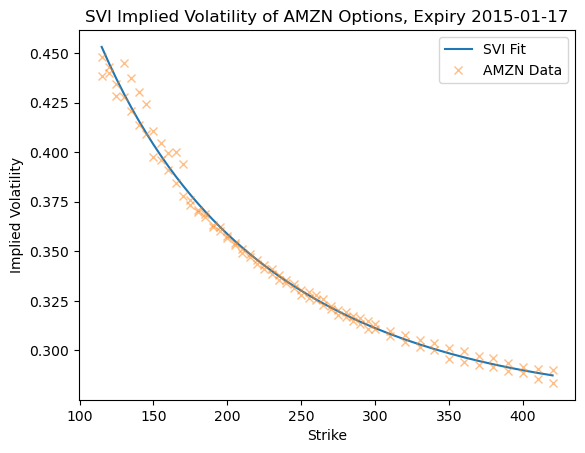

a = -0.3295614796443775 
b =  0.2818695496641046 
rho =  -0.24076071818500858 
m =  -0.12303070141577636 
sigma =  2.2189022767239432


In [4]:
# Initial parameters
a, b, rho, m, sigma = 0.04, 0.4, -0.4, 0.5, 0.1
F_T = S * np.exp((r - q) * T)
x = np.log(K / F_T) # Log moneyness
initial_params = np.array([a, b, rho, m, sigma])

# SVI parameterization
def svi_function(x, a, b, rho, m, sigma):
    return a + b * (rho * (x - m) + np.sqrt((x - m)**2 + sigma**2))

# Function to minimize (sum of squared errors)
def svimse(params):
    a, b, rho, m, sigma = params
    # Calculate the squared errors between model and market implied volatilities
    errors = (vol - svi_function(x, a, b, rho, m, sigma))**2
    return np.sum(errors)

def plot_and_param(params):
    # Bounds for parameters to ensure reasonable values
    # a has no bounds, b>=0, |rho|<1, m has no bounds, sigma>0
    bounds = [(None, None), (0, None), (-1, 1), (None, None), (0.000001, None)]

    # Perform optimization to find the best-fitted parameters
    result = minimize(svimse, params, bounds=bounds, options={'maxiter': 1000})

    # Extract the fitted parameters
    fitted_params = result.x

    #Calculate the implied volatilities using the fitted SVI parameters
    implied_vols_svi = svi_function(x, *fitted_params)

    # Plot
    fig, ax = plt.subplots()
    ax.plot(K, implied_vols_svi, label = "SVI Fit")
    ax.plot(K, vol, 'x', label = 'AMZN Data', alpha = 0.5)
    ax.set_title("SVI Implied Volatility of AMZN Options, Expiry 2015-01-17")
    ax.set_xlabel('Strike')
    ax.set_ylabel("Implied Volatility")
    ax.legend()
    plt.show()

    return fitted_params

params = plot_and_param(initial_params)
print("a =",params[0], "\nb = ", params[1], "\nrho = ", params[2], "\nm = ", params[3], "\nsigma = ", params[4])
